# First-break picking model

## Content
* [Problem description](#Problem-description)
* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Model evaluation](#Model-evaluation)
* [Conclusion](#Conclusion)

## Problem description

Each seismic trace has a time lag before a seismic wave, originated at the shot point, arrives the receiver. This time lag should be specified to enable trace alingment and velocity estimation.

## Dataset

51 seismograms.

Index field records in SEGY file:

In [5]:
import sys
import numpy as np
import pandas as pd
import dill
import matplotlib.pyplot as plt
from functools import partial
from hmmlearn import hmm

sys.path.append('..')

from batchflow import Dataset, Pipeline, B, V

from geolog import SeismicBatch, FieldIndex, SegyFilesIndex, TraceIndex
from geolog.models import HMModel, make_hmm_data

field_index = FieldIndex(name='raw', extra_headers=['offset'],
                         path='/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy')
field_index.head()

,file_id,TraceNumber,offset,TRACE_SEQUENCE_FILE
,raw,,,raw
FieldRecord,,,,
111906,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy,1656,35,1
111906,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy,1657,36,2
111906,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy,1655,78,3
111906,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy,1658,79,4
111906,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy,1654,127,5


Set first field record as a traning subset:

In [6]:
train_set = Dataset(field_index.create_subset(field_index.indices[:1]), SeismicBatch)

Load and the training seismogram:

In [7]:
batch = train_set.next_batch(1).load(components='raw', sort_by='offset')

Show the training seismogram:

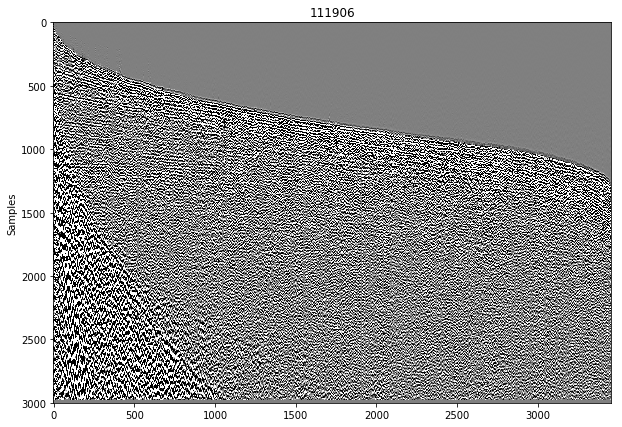

In [8]:
cv = 0.1
batch.show_traces('raw', batch.indices[0], figsize=(10, 7), vmin=-cv, vmax=cv, cmap='gray')

## Model architecture

We exploit a Hidden Markov Model with 2 hidden states. It is supposed that one state corresponds to signal, while the second one corresponds to noise (no-signal). The first change from noise state to signal state is assosiated with seismic wave arrival (first-break moment). It is also supposed that at  each trace is more likely to start at noise state.

Model config:

In [9]:
config_train = {
    'build': True,
    'estimator': hmm.GaussianHMM(n_components=2, n_iter=20, covariance_type="full")
}

## Training

Model training pipeline:

In [33]:
batch_size = 1
cv = 1

train_pipeline = (Pipeline()
                 .init_model("dynamic", HMModel, "HMM", config=config_train)
                 .load(components='raw')
                 .apply_transform(np.clip, a_min=-cv, a_max=cv, src="raw", dst="raw")
                 .gradient(src="raw", dst="grad")
                 .cwt(src="grad", dst="wavelet", scales=[4], wavelet="mexh")
                 .train_model("HMM", make_data=partial(make_hmm_data, components='wavelet'))
                 .run(batch_size=batch_size, n_epochs=1, shuffle=False, drop_last=False, lazy=True))

Run the training pipeline:

In [34]:
(train_set >> train_pipeline).run()

Dump the trained model:

In [35]:
train_pipeline.save_model("HMM", path="_picks_model_noise1.dill")

## Inference

Inference config:

In [36]:
hmmodel_path = "_picks_model_noise1.dill"

config_predict = {
    'build': False,
    'load': {'path': hmmodel_path}
}

with open(hmmodel_path, "rb") as file:
    hmmodel = dill.load(file)
signal_label = np.argmin(hmmodel.startprob_)

def get_first_arrival(arr, signal_label):
    indices = np.where(arr == signal_label)[0]
    return indices[0] if len(indices) else -1

Inference pipeline:

In [37]:
batch_size = 10
cv = 1

test_pipeline = (Pipeline()
                 .init_model("static", HMModel, "HMM", config=config_predict)
                 .load(components='raw', sort_by='offset')
                 .apply_transform(np.clip, a_min=-cv, a_max=cv, src="raw", dst="raw")
                 .gradient(src="raw", dst="grad")
                 .cwt(src="grad", dst="wavelet", scales=[4], wavelet="mexh")
                 .predict_model("HMM", make_data=partial(make_hmm_data, components='wavelet'),
                                save_to=B("hmm_predictions"), mode='w')
                 .to_2d(src="hmm_predictions", dst="hmm_predictions")
                 .apply_to_trace(get_first_arrival, src="hmm_predictions",
                                 dst="hmm_predictions", signal_label=signal_label)
                 .run(batch_size=batch_size, shuffle=False, drop_last=False, n_epochs=1, lazy=True)
                )

Run inference on a test subset (10 field records):

In [38]:
test_set = Dataset(field_index.create_subset(field_index.indices[1:21:2]), SeismicBatch)
batch = (test_set >> test_pipeline).next_batch(10)

## Model evaluation

Show test seismograms and first-break picks:

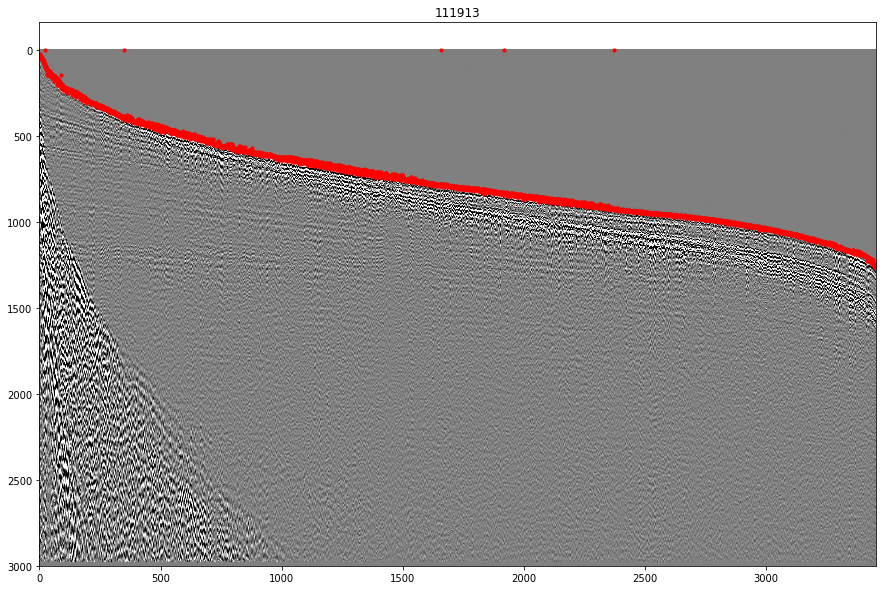

In [57]:
def show_picks(batch, picks, i):
    picks = batch.hmm_predictions[i]
    plt.figure(figsize=(15, 10))
    plt.imshow(batch.raw[i].T, cmap='gray', vmin=-cv, vmax=cv)
    plt.scatter(np.arange(len(picks)), picks, s=10, c='r')
    plt.axes().set_aspect('auto')
    plt.xlim(0, batch.raw[i].shape[0])
    plt.title(batch.indices[i])
    plt.show()
    
show_picks(batch, picks, 3)

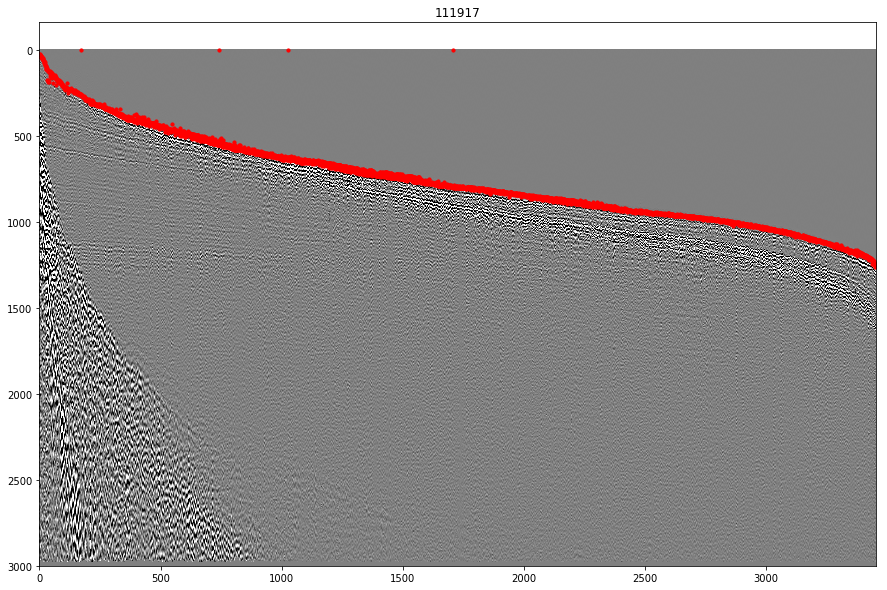

In [58]:
show_picks(batch, picks, 5)

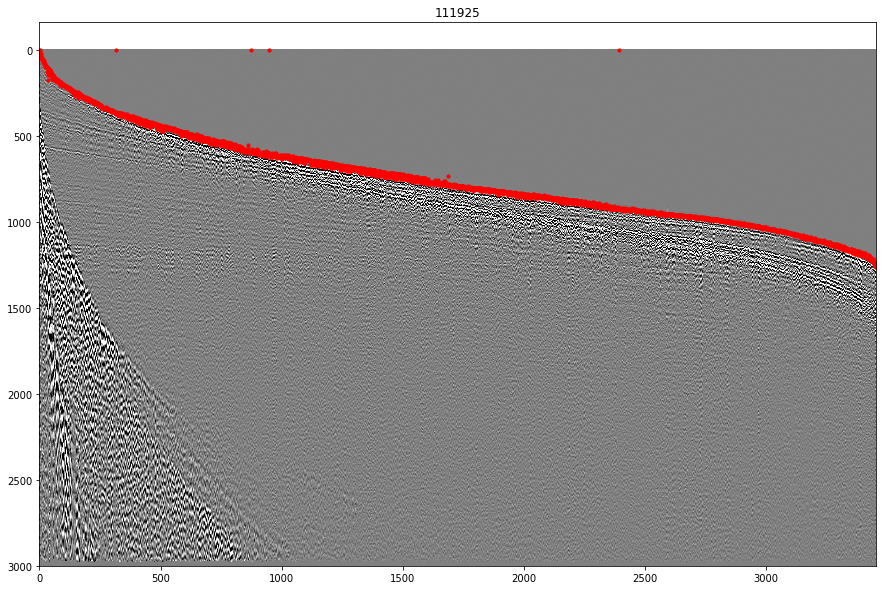

In [59]:
show_picks(batch, picks, 9)

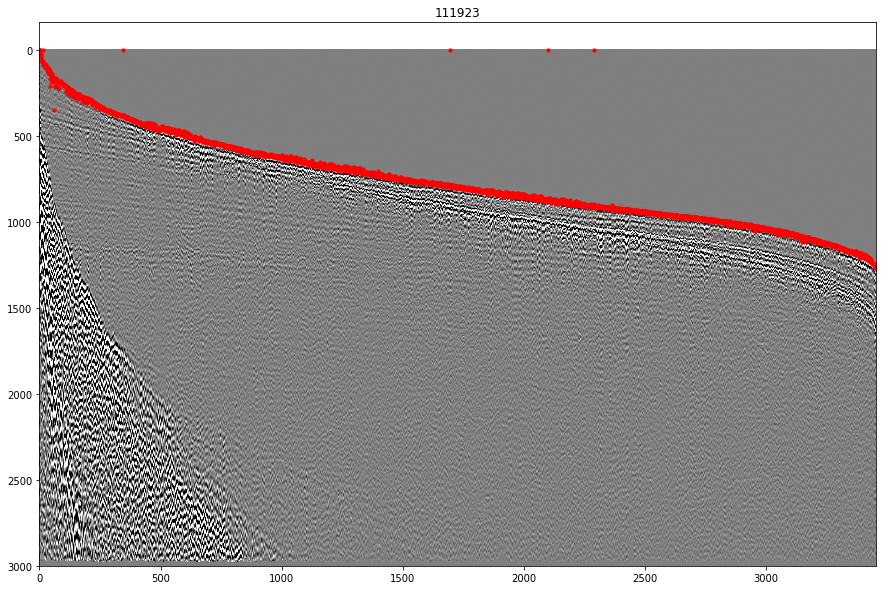

In [60]:
show_picks(batch, picks, 8)

## Conclusion

HMM provides a reasonable estimation of the first arrivals. However, there are rare outlires when the results look inconsistent within neighbour traces. It can be caused by noise in seismic records. To improve results, noise should be supressed before picking. It makes also sence to improve the model and consider neighbour traces.